In [6]:
import numpy as np
import pandas as pd 
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10,7

import sys
#sys.path.append('/Users/ayoubennassiri/Documents/Projects/advancedFML/src') #TODO: Change the append
#sys.path.append('/Users/ayoubennassiri/Documents/Projects/advancedFML/')
sys.path.append('../src') #TODO: Change the append
sys.path.append('..')

# Data Preparation
- Download the data from: http://www.kibot.com/buy.aspx at the: "Free historical data for your data quality analysis" section

- We have the data from the WDC stock and the iShares IVE ETF: https://www.ishares.com/us/products/239728/ishares-sp-500-value-etf

## Tick Data info from kibot
http://www.kibot.com/support.aspx#data_format

- The order of the fields in the tick files (with bid/ask prices) is: Date,Time,Price,Bid,Ask,Size.
- The bid/ask prices are recorded whenever a trade occurs and they represent the "national best bid and offer" (NBBO) prices across multiple exchanges and ECNs.
- For each trade, current best bid/ask values are recorded together with the transaction price and volume. Trade records are not aggregated and all transactions are included in their consecutive order.
- The order of fields in our regular tick files (without bid/ask) is: Date,Time,Price,Size.
- The order of fields in our 1, 5 or 10 second files is: Date,Time,Open,High,Low,Close,Volume. It is the same format used in our minute files.
- The stocks and ETFs data includes pre-market (8:00-9:30 a.m. ET), regular (9:30 a.m.-4:00 p.m. ET.) and after market (4:00-6:30 p.m. ET) sessions.
- Trading for SPY (SPDR S&P 500 ETF) and some other liquid ETFs and stocks usually starts at 4 a.m and ends at 8 p.m. ET.

In [9]:
def prepare_data_kibot(raw_data_path, out_data_path):
    df = pd.read_csv(raw_data_path,
                     header=None,
                     names=['day', 'time', 'price', 'bid', 'ask', 'vol'])
    df['date'] = pd.to_datetime(df['day'] + df['time'],
                                format='%m/%d/%Y%H:%M:%S')
    df['dollar_vol'] = df['price']*df['vol']
    df = df.set_index('date')
    df = df.drop(['day', 'time'],
                 axis=1)
    df = df.drop_duplicates()
    df.to_parquet(out_data_path)

In [12]:
raw_data_path = '../data/raw/IVE_tickbidask.txt'
out_data_path = '../data/interim/IVE_tickbidask.parq'
prepare_data_kibot(raw_data_path, out_data_path)

C:\Users\aennassiri\AppData\Local\Continuum\anaconda3\envs\advancesFML\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [13]:
#out_data_path = '../data/interim/WDC_tickbidask.parq'
out_data_path = '../data/interim/IVE_tickbidask.parq'
df = pd.read_parquet(out_data_path)

C:\Users\aennassiri\AppData\Local\Continuum\anaconda3\envs\advancesFML\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\aennassiri\AppData\Local\Continuum\anaconda3\envs\advancesFML\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\aennassiri\AppData\Local\Continuum\anaconda3\envs\advancesFML\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


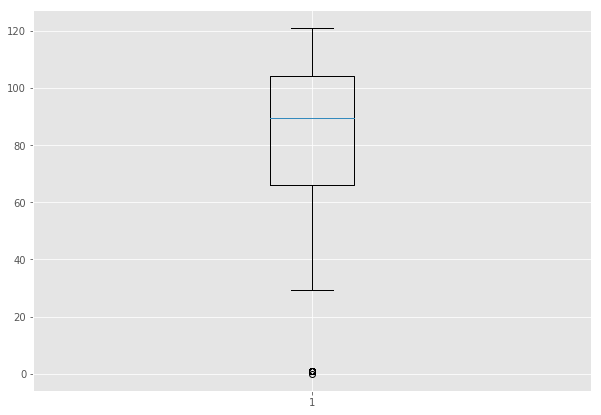

In [14]:
fig, ax = plt.subplots()
_ = ax.boxplot(df.price)

### Outliers removal : 
- It computes the Z-score of each value in the column, relative to the column mean and standard deviation.
- Then is takes the absolute of Z-score because the direction does not matter, only if it is below the threshold.
- If other columns than the prices is needed (e.g bid, ask, vol), this function usage should be extended
- Finally, result of this condition is used to index the dataframe.

In [15]:
outliers = (np.abs(stats.zscore(df.price)) > 3)

In [16]:
# Outliers list
df.loc[outliers]

,price,bid,ask,vol,dollar_vol
date,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,110.0


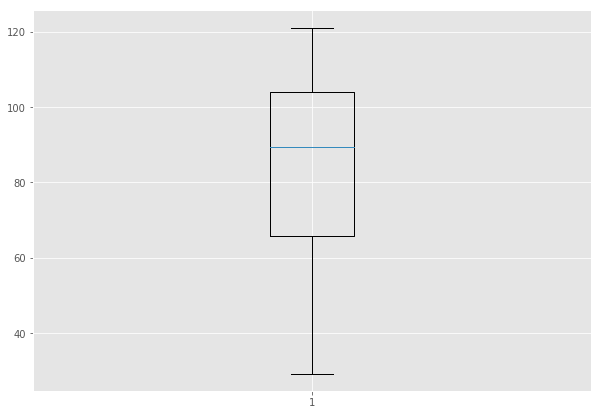

In [17]:
#clean_data_path = '../data/processed/clean_WDC_tickbidask.parq'
clean_data_path = '../data/processed/clean_IVE_tickbidask.parq'

df = df.loc[~outliers]

fig, ax = plt.subplots()
_ = ax.boxplot(df.price)

df.to_parquet(clean_data_path)